Primeros 30 registros del DataFrame:
                                producto.nombre  producto.precio  \
0   NOX AT GENIUS ATTACK 18K AGUSTÍN TAPIA 2024           149.95   
1                           KOMBAT MM3 PRO 2024           125.00   
2                         SIUX ASTRA 3.0 HYBRID            59.95   
3        NOX AT10 GENIUS 12K AGUSTIN TAPIA 2024           161.95   
4                         PALA SIUX FENIX II 3K            89.95   
5        NOX ML10 PRO CUP 3K LUXURY SERIES 2024           142.95   
6       NOX PACK AT GENIUS LIMITED EDITION 2024           229.95   
7           BABOLAT TECHNICAL VIPER LEBRON 2023           199.95   
8                     NOX ML10 PRO CUP COORP 23           104.95   
9         NOX ML10 BAHIA 12K LUXURY SERIES 2024           142.95   
10                          BULLPADEL VERTEX 04           194.95   
11                   PALA SIUX TRILOGY 3 ATTACK            99.00   
12                  SIUX PEGASUS REVOLUTION 12K           129.95   
13         

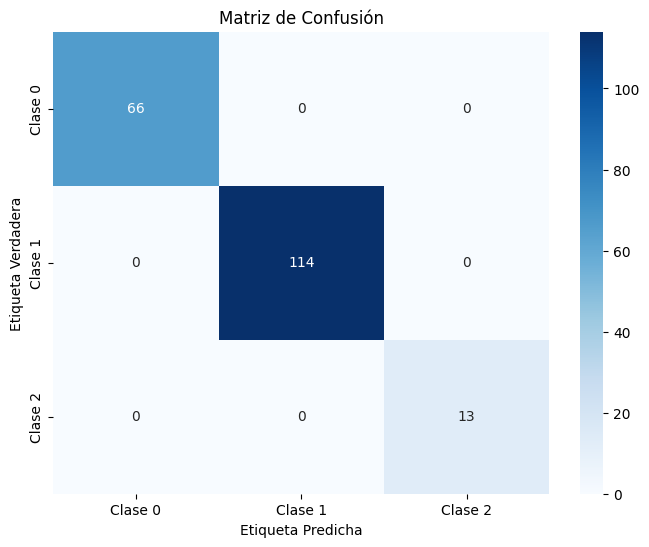

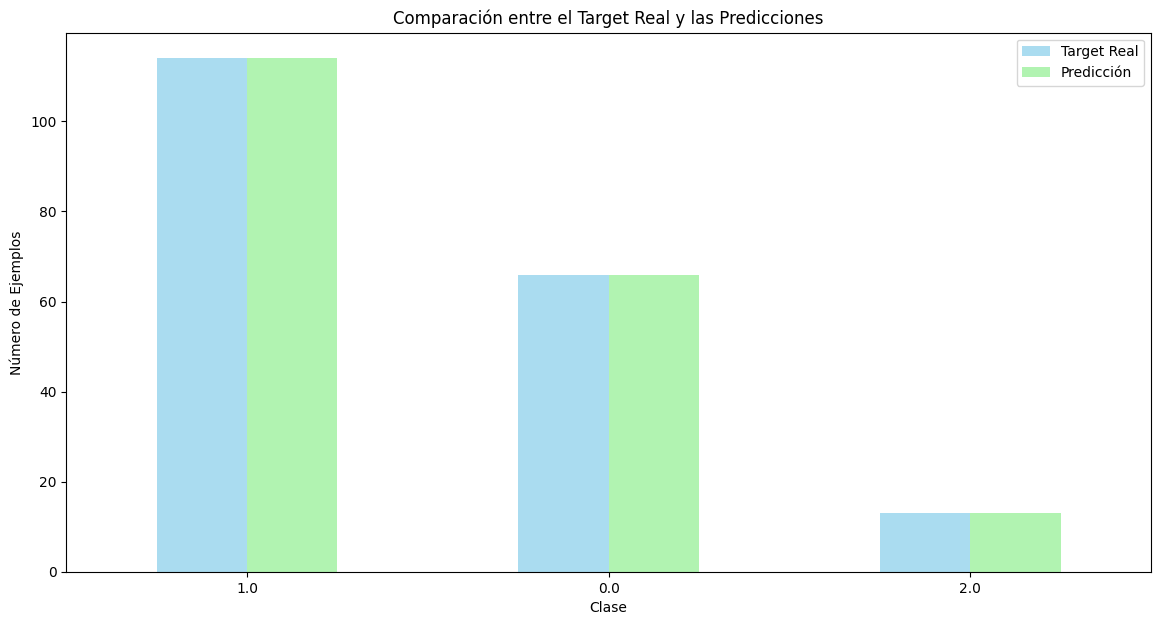

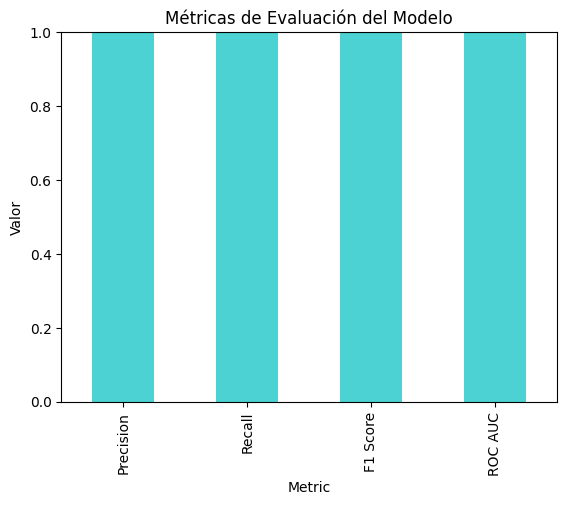

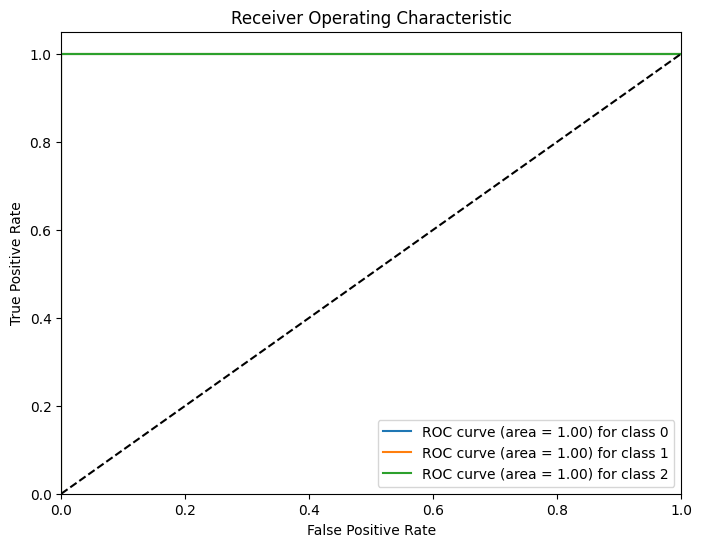

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import label_binarize

def load_data(json_path):
    """Carga el DataFrame desde un archivo JSON."""
    return pd.read_json(json_path, orient='records', lines=True)

def preprocess_data(data_df):
    """Preprocesa los datos convirtiendo características categóricas a numéricas y manejando valores faltantes."""
    label_encoder = LabelEncoder()
    for column in data_df.columns:
        if data_df[column].dtype == 'object':
            data_df[column] = label_encoder.fit_transform(data_df[column].astype(str))
    
    if data_df['nivel_de_juego_numeric'].isna().sum() > 0:
        mean_value = data_df['nivel_de_juego_numeric'].mean()
        data_df['nivel_de_juego_numeric'].fillna(round(mean_value), inplace=True)
    
    features = data_df.drop(columns=['nivel_de_juego_numeric', 'nivel_de_juego_transformado', 'nivel_de_juego_original'])
    target = data_df['nivel_de_juego_numeric']
    
    return features, target

def train_model(X_train, y_train):
    """Entrena un modelo de árbol de decisión."""
    classifier = DecisionTreeClassifier(random_state=42)
    classifier.fit(X_train, y_train)
    return classifier

def plot_confusion_matrix(y_test, y_pred):
    """Genera una gráfica de la matriz de confusión."""
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1', 'Clase 2'], yticklabels=['Clase 0', 'Clase 1', 'Clase 2'])
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.title('Matriz de Confusión')
    plt.show()

def plot_comparison(y_test, y_pred):
    """Genera una gráfica comparativa entre el target real y las predicciones."""
    true_counts = pd.Series(y_test).value_counts()
    pred_counts = pd.Series(y_pred).value_counts()

    comparison_df = pd.DataFrame({'Target Real': true_counts, 'Predicción': pred_counts}).fillna(0)
    
    comparison_df.plot(kind='bar', figsize=(14, 7), color=['skyblue', 'lightgreen'], alpha=0.7)
    plt.title('Comparación entre el Target Real y las Predicciones')
    plt.xlabel('Clase')
    plt.ylabel('Número de Ejemplos')
    plt.xticks(rotation=0)
    plt.legend(['Target Real', 'Predicción'])
    plt.show()

def plot_roc_curve(y_test, y_pred_proba):
    """Genera una gráfica de la curva ROC."""
    # Binarizar las etiquetas para calcular ROC AUC multiclase
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    
    # Calcular ROC AUC para cada clase
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(y_test_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plotear todas las curvas ROC
    plt.figure(figsize=(8, 6))
    
    for i in range(y_test_bin.shape[1]):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_metrics(y_test, y_pred):
    """Genera una gráfica de las métricas de evaluación."""
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # ROC AUC solo para problemas binarios o multiclase con proba
    roc_auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), multi_class='ovr')

    metrics_df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1 Score', 'ROC AUC'],
        'Value': [precision, recall, f1, roc_auc]
    })

    metrics_df.plot(kind='bar', x='Metric', y='Value', legend=False, color='c', alpha=0.7)
    plt.title('Métricas de Evaluación del Modelo')
    plt.ylim(0, 1)
    plt.ylabel('Valor')
    plt.show()

def evaluate_model(classifier, X_test, y_test):
    """Evalúa el modelo y muestra métricas de rendimiento."""
    
    # Obtener probabilidades para la curva ROC
    y_pred_proba = classifier.predict_proba(X_test)

    # Obtener predicciones
    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Precisión del modelo: {accuracy:.2f}")

    print("\nInforme de clasificación:")
    print(classification_report(y_test, y_pred))

    print("\nMatriz de confusión:")
    plot_confusion_matrix(y_test, y_pred)

    plot_comparison(y_test, y_pred)

    plot_metrics(y_test, y_pred)

    # Graficar la curva ROC
    plot_roc_curve(y_test,y_pred_proba)

def main():
   current_dir = os.getcwd()
   json_path = os.path.join(current_dir,'dataframe_resultado.json')

   data_df = load_data(json_path)

   print("Primeros 30 registros del DataFrame:")
   print(data_df.head(30))

   features,target=preprocess_data(data_df)

   X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.2,
   random_state=42)

   classifier=train_model(X_train,y_train)

   evaluate_model(classifier,X_test,y_test)

if __name__=="__main__":
 main()
